## Note
I was seeing some weird cosmology dependence between different velocity field interpolation schemes, but it turns out it was just because the spatial resolution was too low.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["PYBORG_QUIET"] = "yes"  # noqa
os.environ['OPENBLAS_NUM_THREADS'] = '16' # noqa

import borg
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from test import get_vgrid

In [2]:
Nsamp = 5

c_fid = [0.3175, 0.049, 0.6711, 0.9624, 0.834]
Oms = np.linspace(0.1, 0.5, Nsamp)
cosmos = np.array([c_fid for _ in range(Nsamp)])
cosmos[:, 0] = Oms

## Test for one cosmology

In [3]:
cosmo = cosmos[4]
print(cosmo)

[0.5    0.049  0.6711 0.9624 0.834 ]


In [33]:
# SETUP BORG FORWARD MODEL

def gen_ICs(N):
    """Generate ICs in Fourier space."""
    ic = np.fft.rfftn(np.random.randn(N, N, N))/N**(1.5)
    return ic

def build_cosmology(pars):
    cpar = borg.cosmo.CosmologicalParameters()
    cpar.default()
    cpar.omega_m, cpar.omega_b, cpar.h, cpar.n_s, cpar.sigma8 = pars
    cpar.omega_q = 1. - cpar.omega_m
    return cpar

def transfer_EH(chain, box, ai):
    chain.addModel(borg.forward.models.Primordial(box, ai))
    chain.addModel(borg.forward.models.EisensteinHu(box))

def run_borg(
    ic,
    L, N, supersampling,
    ai, af,
    cpar,
    transfer='EH'
):
    # initialize box and chain
    box = borg.forward.BoxModel()
    box.L = (L, L, L)
    box.N = (N, N, N)

    chain = borg.forward.ChainForwardModel(box)
    chain.addModel(borg.forward.models.HermiticEnforcer(box))

    transfer_EH(chain, box, ai)

    # add lpt
    lpt = borg.forward.models.Borg2Lpt(
        box=box, box_out=box,
        ai=ai, af=af,
        supersampling=supersampling
    )
    chain.addModel(lpt)
    chain.setCosmoParams(cpar)

    # forward model

    print('Running forward...')
    chain.forwardModel_v2(ic)

    print('Storing...')
    Npart = lpt.getNumberOfParticles()
    rho = np.empty(chain.getOutputBoxModel().N)
    ppos = np.empty(shape=(Npart, 3))
    pvel = np.empty(shape=(Npart, 3))
    chain.getDensityFinal(rho)
    lpt.getParticlePositions(ppos)
    lpt.getParticleVelocities(pvel)

    print('Velocities...')
    vmodel = borg.forward.velocity.CICModel(box, lpt)
    vcic = np.empty((3, N, N, N), dtype=np.float64)
    vcic = vmodel.getVelocityField()

    vmodel = borg.forward.velocity.SICModel(box, lpt)
    vsic = np.empty((3, N, N, N), dtype=np.float64)
    vsic = vmodel.getVelocityField()

    return rho, vcic, vsic, ppos, pvel

In [34]:
# Set manually
L = 3000  # Mpc/h
N = 64  # number of grid points
zi = 127  # initial redshift
zf = 0.  # final redshift
supersampling = 2
transfer = 'EH'  # Transfer function 'CLASS' or 'EH'

ai = 1/(1+zi)
af = 1/(1+zf)

cpar = build_cosmology(cosmo)

In [35]:
ic = gen_ICs(N)

# Run
rho, vcic, vsic, ppos, pvel = run_borg(
    ic,
    L, N, supersampling,
    ai, af,
    cpar,
    transfer=transfer
) # returns BORG's CIC and SIC velocities

/tmp/ipykernel_111824/4151228418.py:17: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  chain.addModel(borg.forward.models.EisensteinHu(box))
/tmp/ipykernel_111824/4151228418.py:37: DeprecationWarning: Call to deprecated class Borg2Lpt. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  lpt = borg.forward.models.Borg2Lpt(


Running forward...
Storing...
Velocities...


In [36]:
# Calculate Deaglan's velocity field
vfield = get_vgrid(rho, jnp.int64(3000), 9, f=cosmo[0] ** 0.55)

/automnt/data80/mattho/venv/borg/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:146: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


In [37]:
# Setup and calculate kNN velocity field

# Setup
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=6,
                          algorithm='ball_tree', weights='distance', n_jobs=-1)
knn.fit(ppos, pvel)

# Calculate
g = np.linspace(0, L, N)
xyz = np.array(np.meshgrid(g, g, g, indexing='ij'))
vknn = knn.predict(xyz.reshape(3, -1).T).T.reshape(3,N,N,N)

In [38]:
# Setup and calculate Nearest Grid Point (NGP) field
import tqdm

def vfield_NGP(ppos, pvel):
    rhogrid = np.zeros((N, N, N))
    momgrid = np.zeros((3, N, N, N))

    for i in tqdm.tqdm(range(len(ppos))):
        inds = (ppos[i]*N/L) // 1 # NGP
        inds = inds.astype(int)
        rhogrid[inds[0], inds[1], inds[2]] += 1
        momgrid[:,inds[0], inds[1], inds[2]] += pvel[i]
    vgrid = (momgrid/rhogrid[None, ...])
    return vgrid

vngp = vfield_NGP(ppos, pvel)

100%|██████████| 2097152/2097152 [00:24<00:00, 86859.27it/s]


In [39]:
# Compose all into a dictionary, with names
vels = {
    'From Field': vfield,
    'BORG CIC': vcic,
    'BORG SIC': vsic,
    'kNN': vknn,
    'NGP': vngp,
}

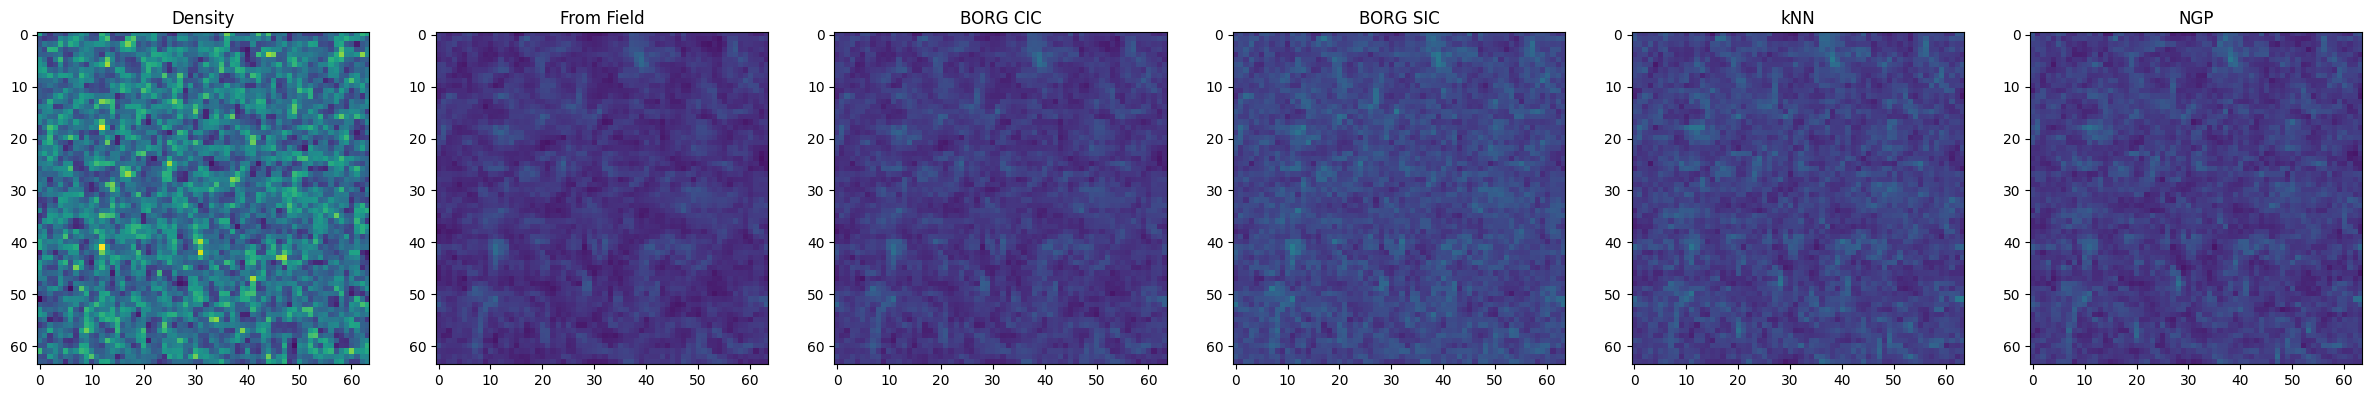

In [40]:
f, axs = plt.subplots(1, len(vels)+1, figsize=(5*(len(vels)+1), 5))

axs[0].imshow(np.mean(rho[50:55], axis=0))
axs[0].set_title('Density')
for i, (k, v) in enumerate(vels.items()):
    axs[i+1].imshow(np.mean(np.linalg.norm(v, axis=0)[50:55], axis=0),
                    vmin=0, vmax=1600)
    axs[i+1].set_title(k)

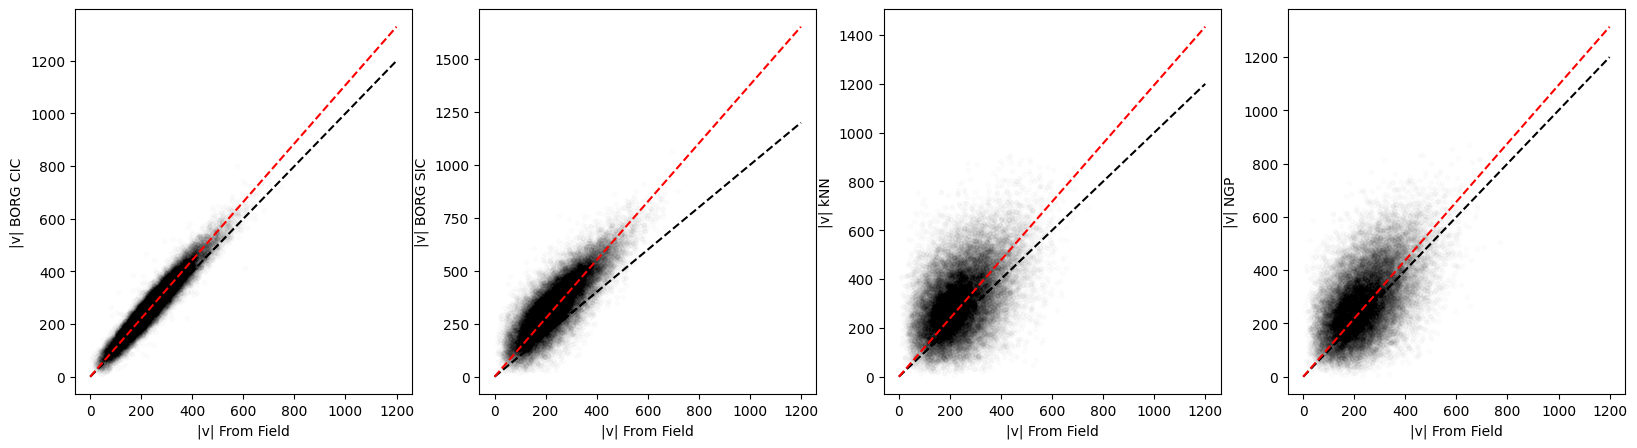

In [41]:
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression

def plot_regression(cube1, cube2, ax, subsample=1):
    x_ = np.linalg.norm(cube1, axis=0).flatten()
    y_ = np.linalg.norm(cube2, axis=0).flatten()

    if subsample < 1:
        mask = np.random.rand(len(x_)) < subsample
        x_ = x_[mask]
        y_ = y_[mask]
    mask = np.isnan(x_) | np.isnan(y_)
    x_ = x_[~mask]
    y_ = y_[~mask]
    
    # train regression
    lr = LinearRegression(fit_intercept=False).fit(x_.reshape(-1, 1), y_)
    xlr = np.linspace(0, 1200, 100)
    ylr = lr.predict(xlr.reshape(-1, 1))

    # create a pandas dataframe
    df = pd.DataFrame({'x': x_, 'y': y_})

    # create a jointplot
    ax.plot([0,1200], [0,1200], 'k--')
    ax.plot(x_, y_, 'k.', alpha=0.01)
    ax.plot(xlr, ylr, 'r--')

    # ax.set_xlim(0, 1200)
    # ax.set_ylim(0, 1400)

klist = ['BORG CIC', 'BORG SIC', 'kNN', 'NGP']
f, axs = plt.subplots(1, len(klist), figsize=(5*(len(klist)), 5))
for i, k in enumerate(klist):
    v = vels[k]
    plot_regression(vels['From Field'], v, axs[i], subsample=0.1)
    axs[i].set_xlabel('|v| From Field')
    axs[i].set_ylabel('|v| ' + k)

## Now for several cosmologies

In [42]:
# Set manually
L = 256  # Mpc/h
N = 64  # number of grid points
zi = 127  # initial redshift
zf = 0.  # final redshift
supersampling = 2
transfer = 'EH'  # Transfer function 'CLASS' or 'EH'

ai = 1/(1+zi)
af = 1/(1+zf)

# Fixed ICs
ic = gen_ICs(N)

In [43]:
vellist = []
for i, cosmo in enumerate(cosmos):
    print(cosmo)

    cpar = build_cosmology(cosmo)

    # Run
    rho, vcic, vsic, ppos, pvel = run_borg(
        ic,
        L, N, supersampling,
        ai, af,
        cpar,
        transfer=transfer
    ) # returns BORG's CIC and SIC velocities


    # Calculate Deaglan's velocity field
    vfield = get_vgrid(rho, jnp.int64(3000), 9., f=cosmo[0] ** 0.55)


    # Setup and calculate kNN velocity field
    # Setup
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=6,
                            algorithm='ball_tree', weights='distance', n_jobs=-1)
    knn.fit(ppos, pvel)

    # Calculate
    g = np.linspace(0, L, N)
    xyz = np.array(np.meshgrid(g, g, g, indexing='ij'))
    vknn = knn.predict(xyz.reshape(3, -1).T).T.reshape(3,N,N,N)


    # Setup and calculate Nearest Grid Point (NGP) field
    vngp = vfield_NGP(ppos, pvel)


    # Compose all into a dictionary, with names
    vels = {
        'From Field': vfield,
        'BORG CIC': vcic,
        'BORG SIC': vsic,
        'kNN': vknn,
        'NGP': vngp,
    }
    vellist.append(vels)

[0.1    0.049  0.6711 0.9624 0.834 ]


/tmp/ipykernel_111824/4151228418.py:17: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  chain.addModel(borg.forward.models.EisensteinHu(box))
/tmp/ipykernel_111824/4151228418.py:37: DeprecationWarning: Call to deprecated class Borg2Lpt. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  lpt = borg.forward.models.Borg2Lpt(


Running forward...
Storing...
Velocities...


/automnt/data80/mattho/venv/borg/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:146: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
100%|██████████| 2097152/2097152 [00:23<00:00, 89942.95it/s]
/tmp/ipykernel_111824/1137969590.py:13: RuntimeWarning: invalid value encountered in divide
  vgrid = (momgrid/rhogrid[None, ...])
/tmp/ipykernel_111824/4151228418.py:17: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  chain.addModel(borg.forward.models.EisensteinHu(box))
/tmp/ipykernel_111824/4151228418.py:37: DeprecationWarning: Call to deprecated class Borg2

[0.2    0.049  0.6711 0.9624 0.834 ]
Running forward...
Storing...
Velocities...


/automnt/data80/mattho/venv/borg/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:146: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
100%|██████████| 2097152/2097152 [00:22<00:00, 92213.91it/s]
/tmp/ipykernel_111824/1137969590.py:13: RuntimeWarning: invalid value encountered in divide
  vgrid = (momgrid/rhogrid[None, ...])
/tmp/ipykernel_111824/4151228418.py:17: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  chain.addModel(borg.forward.models.EisensteinHu(box))
/tmp/ipykernel_111824/4151228418.py:37: DeprecationWarning: Call to deprecated class Borg2

[0.3    0.049  0.6711 0.9624 0.834 ]
Running forward...
Storing...
Velocities...


/automnt/data80/mattho/venv/borg/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:146: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
100%|██████████| 2097152/2097152 [00:23<00:00, 89266.43it/s]
/tmp/ipykernel_111824/1137969590.py:13: RuntimeWarning: invalid value encountered in divide
  vgrid = (momgrid/rhogrid[None, ...])
/tmp/ipykernel_111824/4151228418.py:17: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  chain.addModel(borg.forward.models.EisensteinHu(box))
/tmp/ipykernel_111824/4151228418.py:37: DeprecationWarning: Call to deprecated class Borg2

[0.4    0.049  0.6711 0.9624 0.834 ]
Running forward...
Storing...
Velocities...


/automnt/data80/mattho/venv/borg/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:146: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
100%|██████████| 2097152/2097152 [00:22<00:00, 92541.64it/s]
/tmp/ipykernel_111824/1137969590.py:13: RuntimeWarning: invalid value encountered in divide
  vgrid = (momgrid/rhogrid[None, ...])
/tmp/ipykernel_111824/4151228418.py:17: DeprecationWarning: Call to deprecated class EisensteinHu. (The tailored binding of native forward models are being deprecated in favor of the automatically generated bindings in model_lib)
  chain.addModel(borg.forward.models.EisensteinHu(box))
/tmp/ipykernel_111824/4151228418.py:37: DeprecationWarning: Call to deprecated class Borg2

[0.5    0.049  0.6711 0.9624 0.834 ]
Running forward...
Storing...
Velocities...


/automnt/data80/mattho/venv/borg/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:146: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
100%|██████████| 2097152/2097152 [00:23<00:00, 89166.42it/s]
/tmp/ipykernel_111824/1137969590.py:13: RuntimeWarning: invalid value encountered in divide
  vgrid = (momgrid/rhogrid[None, ...])


[0.1    0.049  0.6711 0.9624 0.834 ]
[0.2    0.049  0.6711 0.9624 0.834 ]
[0.3    0.049  0.6711 0.9624 0.834 ]
[0.4    0.049  0.6711 0.9624 0.834 ]
[0.5    0.049  0.6711 0.9624 0.834 ]


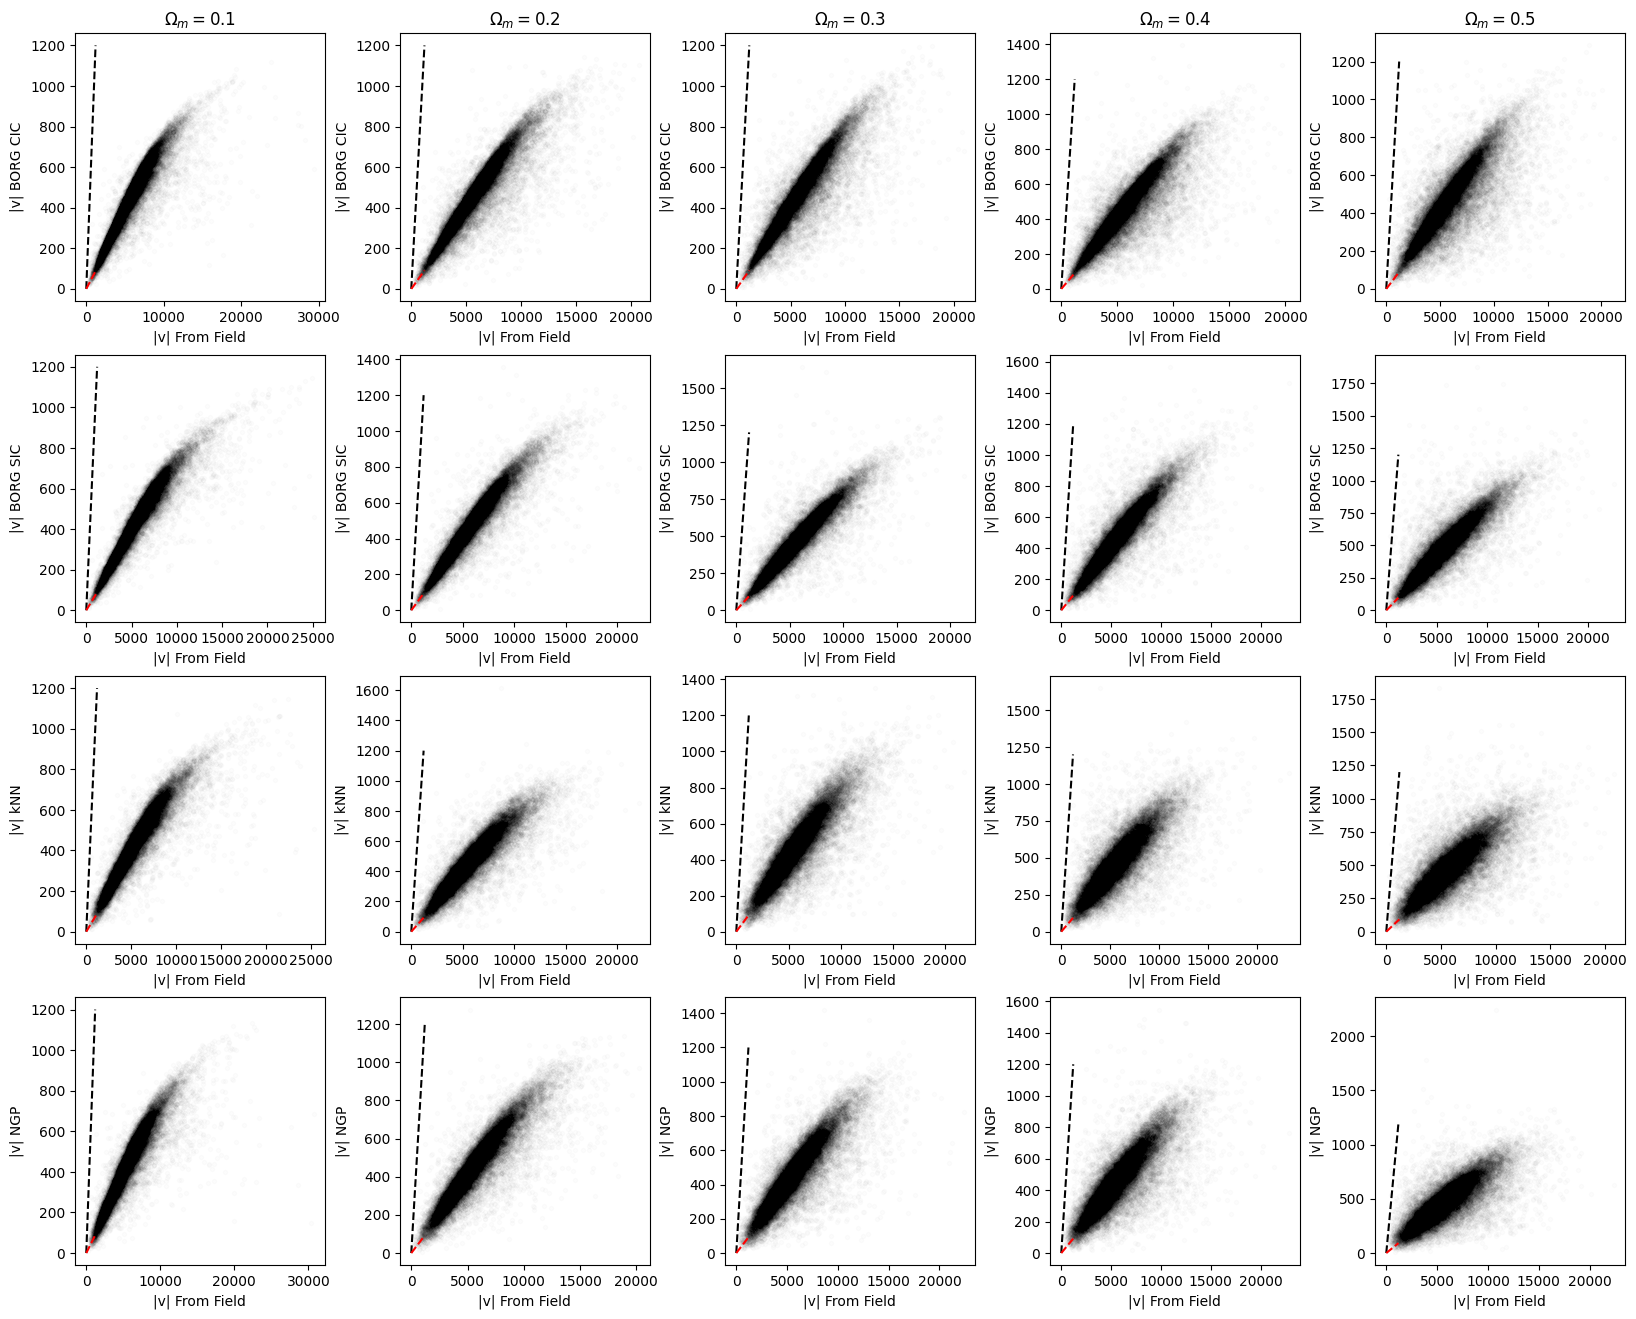

In [44]:
klist = ['BORG CIC', 'BORG SIC', 'kNN', 'NGP']
f, axs = plt.subplots(len(klist), Nsamp, 
                      figsize=(4*Nsamp, 4*(len(klist))),
                      gridspec_kw={'hspace': 0.2, 'wspace': 0.3}
                      )

for i in range(Nsamp):
    print(cosmos[i])

    vels = vellist[i]
    for j, k in enumerate(klist):
        v = vels[k]
        plot_regression(vels['From Field'], v, axs[j,i], subsample=0.1)
        axs[j,i].set_xlabel('|v| From Field')
        axs[j,i].set_ylabel('|v| ' + k)
    axs[0,i].set_title(f'$\Omega_m={cosmos[i,0]:.1f}$')

# f.savefig('../images/vtest.jpg', dpi=300, bbox_inches='tight')

In [45]:
def plot_regression(cube1, cube2, ax, subsample=1, normax=None):
    if normax is not None:
        x_ = cube1[normax]
        y_ = cube2[normax]
    else:
        x_ = np.linalg.norm(cube1, axis=0)
        y_ = np.linalg.norm(cube2, axis=0)
    x_ = x_.flatten()
    y_ = y_.flatten()
    mask = np.isnan(x_) | np.isnan(y_)
    x_ = x_[~mask]
    y_ = y_[~mask]
    

    if subsample < 1:
        mask = np.random.rand(len(x_)) < subsample
        x_ = x_[mask]
        y_ = y_[mask]
    
    # train regression
    lr = LinearRegression(fit_intercept=False).fit(x_.reshape(-1, 1), y_)
    xlr = np.linspace(0, 1200, 100)
    ylr = lr.predict(xlr.reshape(-1, 1))

    # create a pandas dataframe
    df = pd.DataFrame({'x': x_, 'y': y_})

    # create a jointplot
    ax.plot([0,1200], [0,1200], 'k--')
    ax.plot(x_, y_, 'k.', alpha=0.01)
    ax.plot(xlr, ylr, 'r--')

    ax.set_xlim(0, 1200)
    ax.set_ylim(0, 1400)

[0.1    0.049  0.6711 0.9624 0.834 ]
[0.2    0.049  0.6711 0.9624 0.834 ]
[0.3    0.049  0.6711 0.9624 0.834 ]
[0.4    0.049  0.6711 0.9624 0.834 ]
[0.5    0.049  0.6711 0.9624 0.834 ]


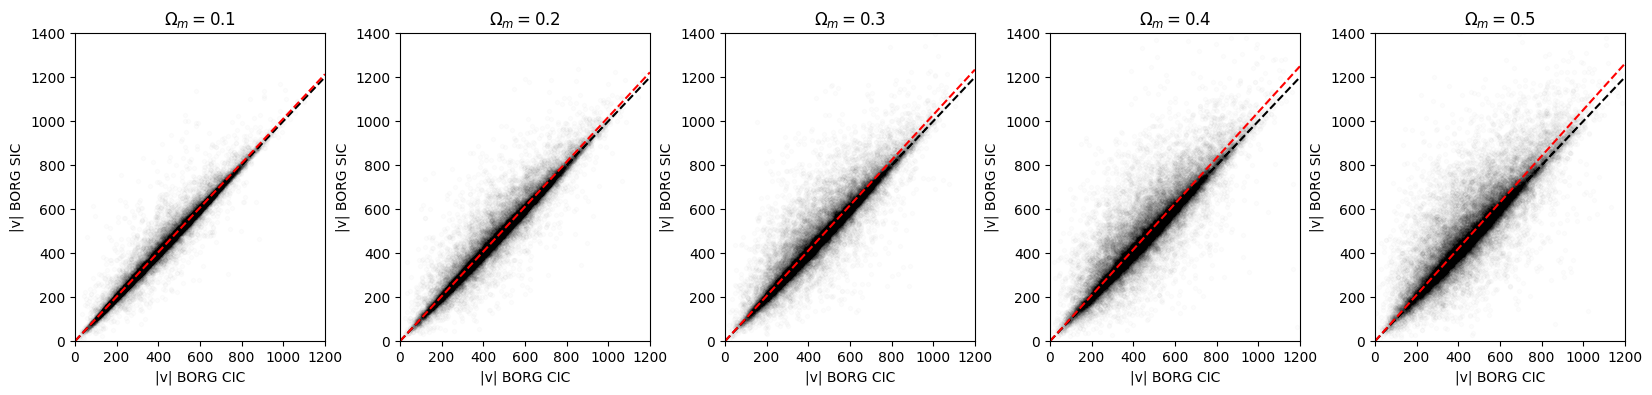

In [46]:

f, axs = plt.subplots(1, Nsamp, 
                      figsize=(4*Nsamp, 4),
                      gridspec_kw={'hspace': 0.2, 'wspace': 0.3}
                      )

for i in range(Nsamp):
    print(cosmos[i])

    vels = vellist[i]
    plot_regression(vels['BORG CIC'], vels['BORG SIC'], axs[i], subsample=0.1)
    axs[i].set_xlabel('|v| BORG CIC')
    axs[i].set_ylabel('|v| BORG SIC')
    axs[i].set_title(f'$\Omega_m={cosmos[i,0]:.1f}$')

# f.savefig('../images/vtest.jpg', dpi=300, bbox_inches='tight')

[0.1    0.049  0.6711 0.9624 0.834 ]
[0.2    0.049  0.6711 0.9624 0.834 ]
[0.3    0.049  0.6711 0.9624 0.834 ]
[0.4    0.049  0.6711 0.9624 0.834 ]
[0.5    0.049  0.6711 0.9624 0.834 ]


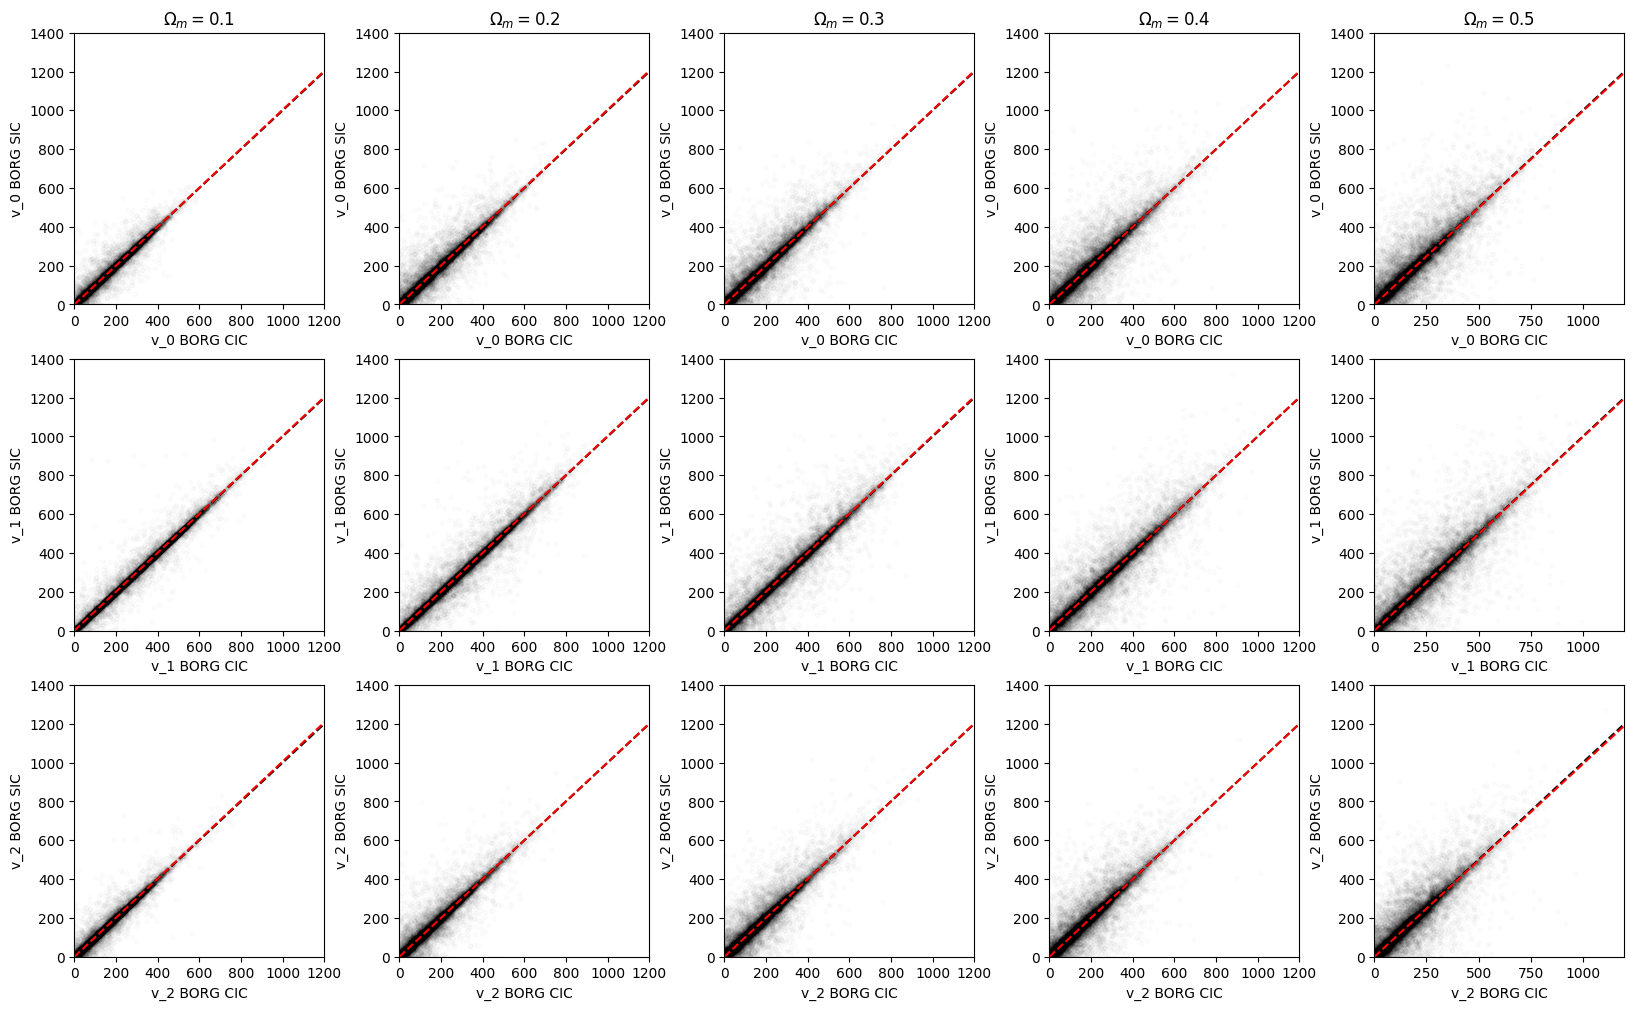

In [47]:

f, axs = plt.subplots(3, Nsamp, 
                      figsize=(4*Nsamp, 4*3),
                      gridspec_kw={'hspace': 0.2, 'wspace': 0.3}
                      )

for i in range(Nsamp):
    print(cosmos[i])

    vels = vellist[i]
    for j in range(3):
        plot_regression(vels['BORG CIC'], vels['BORG SIC'], axs[j,i], subsample=0.1,
                        normax=j)
        axs[j,i].set_xlabel(f'v_{j} BORG CIC')
        axs[j,i].set_ylabel(f'v_{j} BORG SIC')
    axs[0,i].set_title(f'$\Omega_m={cosmos[i,0]:.1f}$')

# f.savefig('../images/vtest.jpg', dpi=300, bbox_inches='tight')

[0.1    0.049  0.6711 0.9624 0.834 ]
[0.2    0.049  0.6711 0.9624 0.834 ]
[0.3    0.049  0.6711 0.9624 0.834 ]
[0.4    0.049  0.6711 0.9624 0.834 ]
[0.5    0.049  0.6711 0.9624 0.834 ]


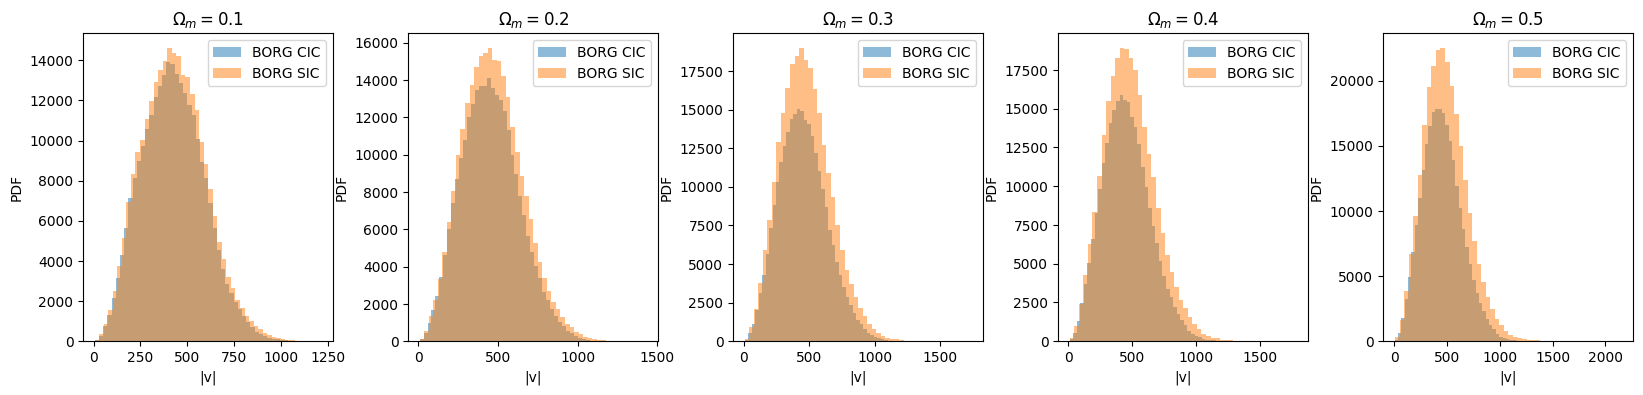

In [48]:
klist = ['BORG CIC', 'BORG SIC', 'kNN', 'NGP']
f, axs = plt.subplots(1, Nsamp, 
                      figsize=(4*Nsamp, 4),
                      gridspec_kw={'hspace': 0.2, 'wspace': 0.3}
                      )

for i in range(Nsamp):
    print(cosmos[i])

    vels = vellist[i]

    vnorm = np.linalg.norm(vels['BORG CIC'], axis=0).flatten()
    axs[i].hist(vnorm, bins=50, alpha=0.5, label='BORG CIC')
    vnorm = np.linalg.norm(vels['BORG SIC'], axis=0).flatten()
    axs[i].hist(vnorm, bins=50, alpha=0.5, label='BORG SIC')
    # axs[i].set_xlabel('|v| BORG CIC')
    # axs[i].set_ylabel('|v| BORG SIC')
    axs[i].set_xlabel('|v|')
    axs[i].set_ylabel('PDF')
    axs[i].set_title(f'$\Omega_m={cosmos[i,0]:.1f}$')
    axs[i].legend()

# f.savefig('../images/vtest.jpg', dpi=300, bbox_inches='tight')

In [ ]:
vels['BORG CIC'].shape 

(3, 64, 64, 64)